In [145]:
from __future__ import print_function, division
import pandas as pd
import numpy as np
import requests
import pickle
from pandas.core import datetools

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
from seaborn import plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
import time

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [51]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)

# Data Scraping

# Clean Data

# Data Exploration

In [88]:
Points_Statistics_df = pickle.load(open('data/Points_vs_Statistics.p', 'rb'))

In [90]:
Points_Statistics_df.head()

,season,team,points,shots_pg,discipline_yellow,discipline_red,possession,pass_success,aerials_won,shots_conceded_pg,tackles_pg,interceptions_pg,fouls_pg,offsides_pg,shots_ot_pg,dribbles_pg,fouled_pg
0,2010 - 2011,Barcelona,96,15.8,71,2,67.4,89.6,6.2,7.4,18.5,18.2,10.6,3.9,7.3,14.7,13.4
1,2010 - 2011,Real Madrid,92,19.1,94,7,55.0,82.9,10.1,10.2,22.4,21.8,14.2,3.8,8.0,11.7,13.7
2,2010 - 2011,Valencia,71,13.1,112,8,54.6,80.0,11.8,13.4,19.2,23.3,16.0,2.8,5.1,7.9,12.1
3,2010 - 2011,Villarreal,62,13.9,88,5,52.7,82.2,7.8,12.0,22.8,24.6,12.4,2.2,5.4,9.2,16.4
4,2010 - 2011,Sevilla,58,13.8,100,7,52.7,80.1,13.7,12.6,19.3,20.4,14.5,2.2,5.5,7.7,14.9


In [91]:
Points_Statistics_df.columns

Index(['season', 'team', 'points', 'shots_pg', 'discipline_yellow',
       'discipline_red', 'possession', 'pass_success', 'aerials_won',
       'shots_conceded_pg', 'tackles_pg', 'interceptions_pg', 'fouls_pg',
       'offsides_pg', 'shots_ot_pg', 'dribbles_pg', 'fouled_pg'],
      dtype='object')

## Correlations between final points and features. 

In [92]:
#Let's see the correlations between the final team points with diffrent variables
Points_Statistics_df.corr().sort_values('points')
# points and tackles_pg has a correlation of 0.021. It's really low. Thus tackles_pg will be excluded from the model.

# Several features are highlly correlated with each other, such as shots_pg with shots_og_pg, discipline_yellow with fouls_pg and possession with pass_success. We'll come back to the multicollinearity problem later. 

,points,shots_pg,discipline_yellow,discipline_red,possession,pass_success,aerials_won,shots_conceded_pg,tackles_pg,interceptions_pg,fouls_pg,offsides_pg,shots_ot_pg,dribbles_pg,fouled_pg
shots_conceded_pg,-0.636550,-0.455999,0.375049,0.289173,-0.564062,-0.506937,0.112322,1.000000,0.057106,0.309091,0.353280,-0.287218,-0.538155,-0.540689,-0.111676
discipline_yellow,-0.483785,-0.333550,1.000000,0.441729,-0.438955,-0.529490,0.145392,0.375049,0.228712,0.293482,0.740530,-0.178330,-0.451294,-0.444416,-0.006553
fouls_pg,-0.447149,-0.400628,0.740530,0.356949,-0.552007,-0.644460,0.272430,0.353280,0.277587,0.314656,1.000000,-0.149707,-0.479082,-0.546391,-0.178470
discipline_red,-0.370104,-0.132238,0.441729,1.000000,-0.228531,-0.283500,0.116775,0.289173,0.156889,0.220819,0.356949,-0.142730,-0.250165,-0.335623,0.059555
aerials_won,-0.327054,-0.397959,0.145392,0.116775,-0.467095,-0.555623,1.000000,0.112322,-0.009988,-0.239704,0.272430,-0.377915,-0.474952,-0.361278,-0.349827
interceptions_pg,-0.230981,-0.123078,0.293482,0.220819,-0.252960,-0.352741,-0.239704,0.309091,0.477674,1.000000,0.314656,0.102373,-0.172496,-0.495694,0.070736
tackles_pg,0.016435,0.036475,0.228712,0.156889,-0.130876,-0.191562,-0.009988,0.057106,1.000000,0.477674,0.277587,0.118622,-0.030039,-0.275303,0.167338
fouled_pg,0.235595,0.307255,-0.006553,0.059555,0.394211,0.384467,-0.349827,-0.111676,0.167338,0.070736,-0.178470,0.161226,0.308641,0.205582,1.000000
offsides_pg,0.534218,0.583614,-0.178330,-0.142730,0.495478,0.423935,-0.377915,-0.287218,0.118622,0.102373,-0.149707,1.000000,0.636384,0.235657,0.161226
dribbles_pg,0.585084,0.524475,-0.444416,-0.335623,0.683674,0.764941,-0.361278,-0.540689,-0.275303,-0.495694,-0.546391,0.235657,0.605890,1.000000,0.205582


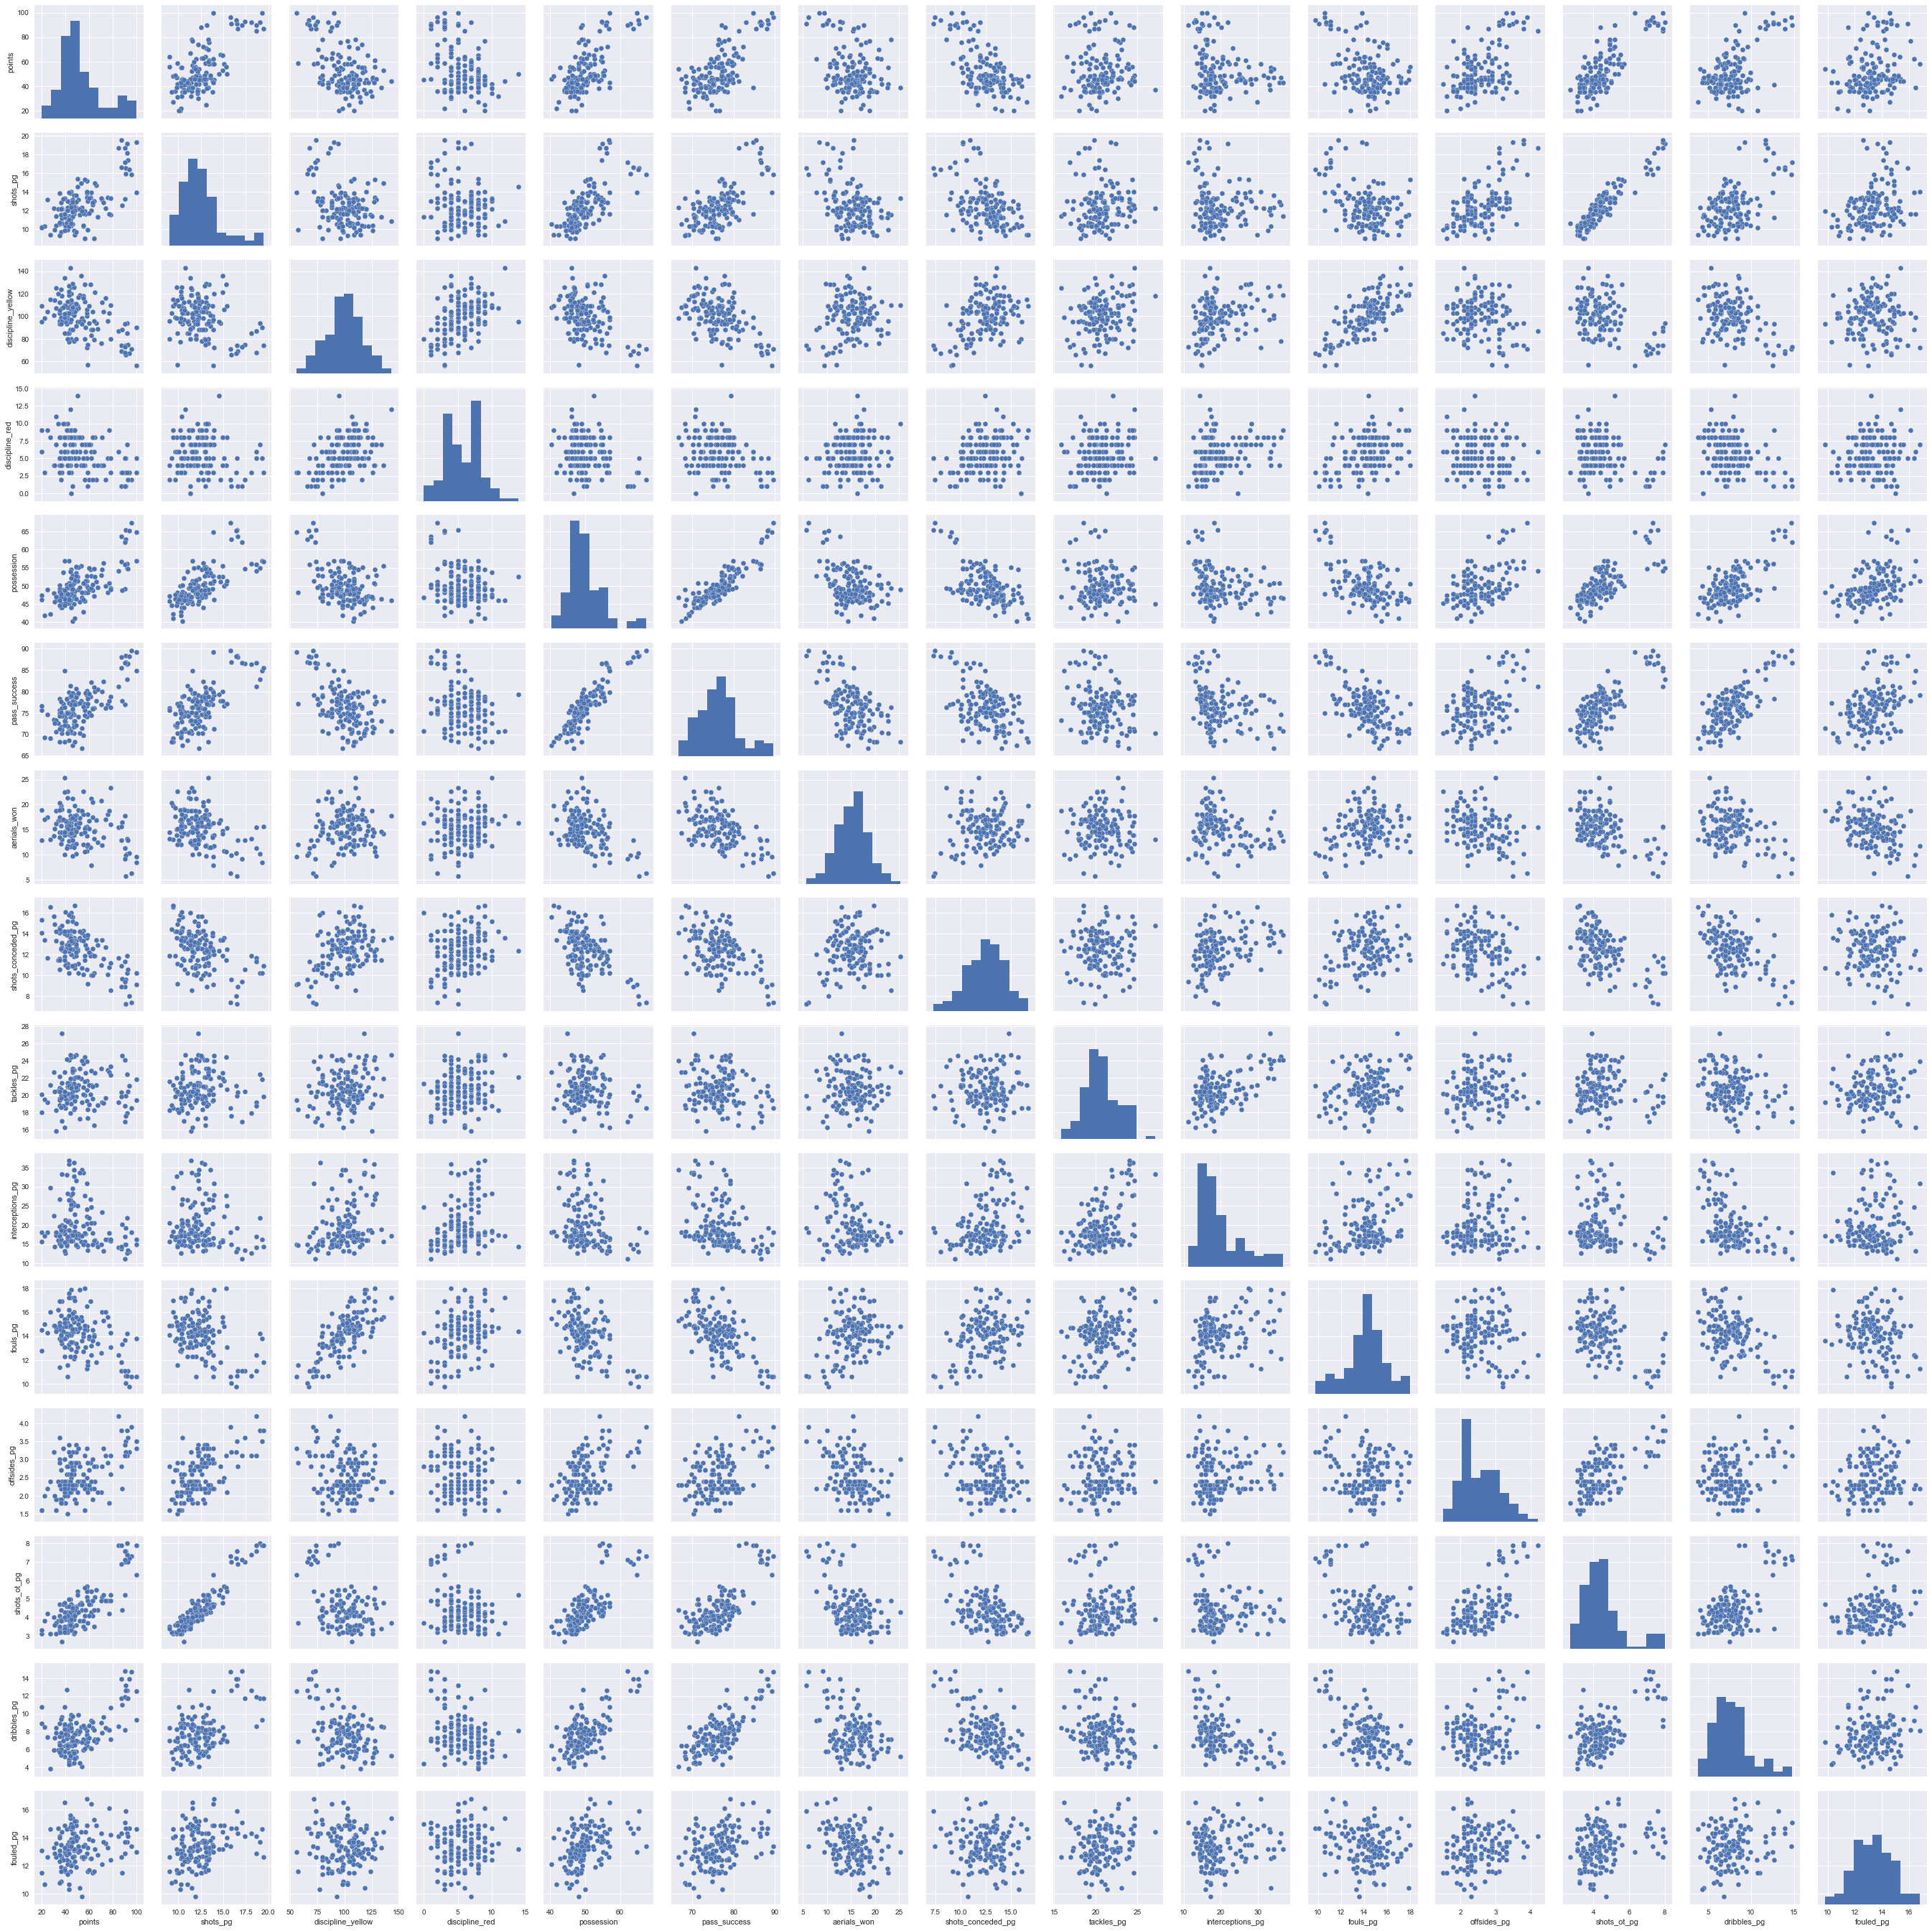

In [93]:
sns.pairplot(Points_Statistics_df);

## Simple linear regression

In [94]:
#We first have a look at the linear regression results for team points with all the features that have correlations over 0.1.

lm1 = smf.ols('points ~ shots_pg + discipline_yellow + discipline_red + possession + pass_success + aerials_won + shots_conceded_pg + interceptions_pg + fouls_pg + offsides_pg + shots_ot_pg + dribbles_pg+ fouled_pg', data=Points_Statistics_df)
fit1 = lm1.fit()
fit1.summary()

#Parameters Interpretation:
#R-squared: 0.764  pretty good, the model can explain 76.4% variance of the final points
#adj R-squared: 0.740  good
#F-statistic: 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 points   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     31.36
Date:                Wed, 19 Jul 2017   Prob (F-statistic):           2.67e-33
Time:                        17:19:37   Log-Likelihood:                -502.41
No. Observations:                 140   AIC:                             1033.
Df Residuals:                     126   BIC:                             1074.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -47.5882     37.468     -1.270      0.206    -121.736      26.560
shots_pg             -2.8754      1.121     -2.565      0.011      -5.094      -0.657
discipline_yellow    -0.0392      0.080     -0.488      0.627      -0.198       0.120
discipline_red       -0.7094      0.368     -1.928      0.056      -1.438       0.019
possession           -0.6577      0.412     -1.597      0.113      -1.473       0.157
pass_success          1.3156      0.519      2.536      0.012       0.289       2.342
aerials_won           0.8330      0.364      2.285      0.024       0.112       1.554
shots_conceded_pg    -2.1728      0.568     -3.824      0.000      -3.297      -1.048
interceptions_pg      0.2341      0.198      1.183      0.239      -0.158       0.626
fouls_pg              0.7667      0.783      0.979      0.330      -0.784       2.317
offsides_pg           2.3666      2.050      1.155      0.250      -1.690       6.423
shots_ot_pg          14.1354      2.608      5.419      0.000       8.973      19.297
dribbles_pg           0.1062      0.629      0.169      0.866      -1.140       1.352
fouled_pg             0.3672      0.687      0.535      0.594      -0.992       1.727
==============================================================================
Omnibus:                        0.216   Durbin-Watson:                   1.462
Prob(Omnibus):                  0.898   Jarque-Bera (JB):                0.100
Skew:                           0.065   Prob(JB):                        0.951
Kurtosis:                       3.020   Cond. No.                     6.77e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.77e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [99]:
# try removing the top three features with the hightes p value: 'dribbles_pg', discipline_yellow' and 'fouled_pg' and see if that improves adj R-squared.

lm2 = smf.ols('points ~ shots_pg + discipline_red + possession + pass_success + aerials_won + shots_conceded_pg + interceptions_pg + fouls_pg + offsides_pg + shots_ot_pg', data=Points_Statistics_df)
fit2 = lm2.fit()
fit2.summary()

#The removal of three high-p-value features does improve adj R-squared from 0.740 to 0.745.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 points   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     41.55
Date:                Wed, 19 Jul 2017   Prob (F-statistic):           1.33e-35
Time:                        17:25:10   Log-Likelihood:                -502.66
No. Observations:                 140   AIC:                             1027.
Df Residuals:                     129   BIC:                             1060.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -48.9562     36.766     -1.332      0.185    -121.698      23.786
shots_pg             -2.9743      1.083     -2.746      0.007      -5.117      -0.831
discipline_red       -0.7301      0.353     -2.069      0.041      -1.428      -0.032
possession           -0.6557      0.401     -1.634      0.105      -1.450       0.138
pass_success          1.3960      0.490      2.847      0.005       0.426       2.366
aerials_won           0.8479      0.347      2.440      0.016       0.160       1.535
shots_conceded_pg    -2.1863      0.549     -3.983      0.000      -3.272      -1.100
interceptions_pg      0.2445      0.183      1.339      0.183      -0.117       0.606
fouls_pg              0.5539      0.630      0.879      0.381      -0.692       1.800
offsides_pg           2.2052      1.997      1.104      0.272      -1.746       6.156
shots_ot_pg          14.4572      2.499      5.785      0.000       9.513      19.402
==============================================================================
Omnibus:                        0.180   Durbin-Watson:                   1.468
Prob(Omnibus):                  0.914   Jarque-Bera (JB):                0.072
Skew:                           0.055   Prob(JB):                        0.965
Kurtosis:                       3.016   Cond. No.                     4.66e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.66e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [100]:
# try removing another two features with the hightes p value: 'fouls_pg' and offsides_pg', and see if that improves adj R-squared.

lm3 = smf.ols('points ~ shots_pg + discipline_red + possession + pass_success + aerials_won + shots_conceded_pg + interceptions_pg + shots_ot_pg', data = Points_Statistics_df)
fit3 = lm3.fit()
fit3.summary()

#The removal of another two high-p-value features further improves adj R-squared from 0.745 to 0.744. I'll keep the features in fit2 for further analysis.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 points   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     51.47
Date:                Wed, 19 Jul 2017   Prob (F-statistic):           8.35e-37
Time:                        17:25:16   Log-Likelihood:                -503.96
No. Observations:                 140   AIC:                             1026.
Df Residuals:                     131   BIC:                             1052.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -26.7623     30.721     -0.871      0.385     -87.536      34.012
shots_pg             -3.0141      1.080     -2.792      0.006      -5.150      -0.878
discipline_red       -0.6773      0.345     -1.963      0.052      -1.360       0.005
possession           -0.5612      0.396     -1.416      0.159      -1.345       0.223
pass_success          1.1740      0.461      2.547      0.012       0.262       2.086
aerials_won           0.7993      0.346      2.311      0.022       0.115       1.483
shots_conceded_pg    -2.1591      0.549     -3.936      0.000      -3.244      -1.074
interceptions_pg      0.2807      0.180      1.559      0.121      -0.076       0.637
shots_ot_pg          15.2136      2.373      6.412      0.000      10.520      19.907
==============================================================================
Omnibus:                        0.160   Durbin-Watson:                   1.472
Prob(Omnibus):                  0.923   Jarque-Bera (JB):                0.075
Skew:                           0.057   Prob(JB):                        0.963
Kurtosis:                       3.000   Cond. No.                     3.84e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.84e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [102]:
columns_to_keep = ['points', 'shots_pg', 'discipline_red', 'possession', 'pass_success', 'aerials_won', 'shots_conceded_pg', 'tackles_pg', 'interceptions_pg', 'fouls_pg', 'offsides_pg', 'shots_ot_pg']

## Regularization

In [248]:

def pseudo_cross_val_ridge_score(df, num_fold, alpha):
    num_row_in_fold = len(df.index)//num_fold
    df = df.sample(frac=1, random_state = 100).reset_index(drop = True)
    scores = []
    for i in range(num_fold):
        test_start = (num_row_in_fold * i)
        test_end = (num_row_in_fold * (i + 1)) + 1
        
        test = df.iloc[test_start : test_end]
        train = df.drop(df.index[test_start : test_end])
        
        y_train = train['points']
        X_train = train.drop('points', axis = 1) 
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        
        y_test = test['points']
        X_test = test.drop('points', axis = 1) 
        X_test_scaled = scaler.transform(X_test)
        
        model= Ridge(alpha = alpha)
        model.fit(X_train_scaled, y_train)
        scores.append(model.score(X_test_scaled, y_test))
    return np.mean(scores)

In [256]:
def ridge_optimize_alpha(alphas):
    max_score = 0
    optimized_alpha = 0
    for alpha in alphas:
        score = pseudo_cross_val_ridge_score(Points_Statistics_df[columns_to_keep], 5, alpha)
        if score > max_score:
            max_score = score
            optimized_alpha = alpha
    print('max_score: ', max_score)
    print('optimized_alpha: ', optimized_alpha)

In [257]:
alphas = np.arange(0, 10, 0.01)
ridge_optimize_alpha(alphas)

max_score:  0.728329616056
optimized_alpha:  0.76


In [209]:
def pseudo_cross_val_lasso_score(df, num_fold, alpha):
    num_row_in_fold = len(df.index)//num_fold
    df = df.sample(frac=1, random_state = 100).reset_index(drop = True)
    scores = []
    for i in range(num_fold):
        test_start = (num_row_in_fold * i)
        test_end = (num_row_in_fold * (i + 1)) + 1
        
        test = df.iloc[test_start : test_end]
        train = df.drop(df.index[test_start : test_end])
        
        y_train = train['points']
        y_test = test['points']
        
        X_train = train.drop('points', axis = 1)
        X_test = test.drop('points', axis = 1) 
         
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        
        model= Lasso(alpha = alpha)
        model.fit(X_train_scaled, y_train)
        scores.append(model.score(X_test_scaled, y_test))
    return np.mean(scores)

In [ ]:
def lasso_optimize_alpha(alphas):
    max_score = 0
    optimized_alpha = 0
    for alpha in alphas:
        score = pseudo_cross_val_lasso_score(Points_Statistics_df[columns_to_keep], 5, alpha)
        if score > max_score:
            max_score = score
            optimized_alpha = alpha
    print('max_score: ', max_score)
    print('optimized_alpha: ', optimized_alpha)

In [259]:
alphas = np.arange(0, 10, 0.01)
lasso_optimize_alpha(alphas)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


max_score:  0.735928907468
optimized_alpha:  0.09


In [224]:
def pseudo_cross_val_elasticnet_score(df, num_fold, alpha, l1_ratio):
    print(alpha)
    print(l1_ratio)
    num_row_in_fold = len(df.index)//num_fold
    df = df.sample(frac=1, random_state = 100).reset_index(drop = True)
    scores = []
    for i in range(num_fold):
        test_start = (num_row_in_fold * i)
        test_end = (num_row_in_fold * (i + 1)) + 1
        test = df.iloc[test_start : test_end]
        train = df.drop(df.index[test_start : test_end])
        X_train = train.drop('points', axis = 1) 
        y_train = train['points']
        X_test = test.drop('points', axis = 1) 
        y_test = test['points']
        model= ElasticNet(alpha = alpha, l1_ratio = l1_ratio)
        model.fit(X_train, y_train)
        scores.append(model.score(X_test, y_test))
    return np.mean(scores)

In [ ]:
def elasticnet_optimize_alpha_l1_ratio(alphas, l1_ratios):
    max_score = 0
    optimized_alpha = 0
    optimized_l1_raio = 0
    for alpha in alphas:
        for l1_ratio in l1_ratios:
            score = pseudo_cross_val_elasticnet_score(Points_Statistics_df[columns_to_keep], 5, alpha, l1_ratio)
            if score > max_score:
                max_score = score
                optimized_alpha = alpha
                optimized_l1_raio = l1_ratio
    print('max_score: ', max_score)
    print('optimized_alpha: ', optimized_alpha)
    print('optimized_l1_ratio: ', optimized_l1_ratio)

In [ ]:
alphas = np.arange(0, 10, 0.01)
l1_ratios = np.arange(0, 1, 0.01)
elasticnet_optimize_alpha_l1_ratio(alphas, l1_ratios)

# Multicollinearity

# Model Visualization